# Purpose

1) Identify the baseline data for China 

2) Create a baseline SIRD model for China

3) Create a SELIRCD model for China

4) Evaluate SELIRCD by comparing results to raw data and to SIRD


# Data

We will be working with cumulative China data from China NHC (National Health Commission).

In [122]:
from scipy.integrate import odeint
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import lmfit
from lmfit.lineshapes import gaussian, lorentzian
from helpers.plot import plotter
import matplotlib.dates as mdates

In [29]:
#Beds data for most countries, most recent year documented, beds per 10,000 people
beds = pd.read_csv("Data/beds_UNdata.csv", header=0)
idx = beds.groupby(['country_area'])['years'].transform(max) == beds['years']
beds = beds[['country_area','years','beds']]
beds = beds[idx]
beds

,country_area,years,beds
0,Afghanistan,2010,4
2,Albania,2009,28
4,Algeria,2004,17
5,Andorra,2009,25
7,Angola,2005,8
...,...,...,...
315,Venezuela (Bolivarian Republic of),2009,11
317,Viet Nam,2009,31
319,Yemen,2010,7
321,Zambia,2010,20


In [30]:
#Age group demographics for some countries, for both sexes, most recent year of data (orig data 1955-2019)
#TODO: Can we predict more accurate population numbers by extrapolation? (LOW priority)
agegroups = pd.read_csv("Data/agegroups_UNdata.csv", header=0)
idx = agegroups.groupby(['country_area'])['year'].transform(max) == agegroups['year']
agegroups = agegroups[['country_area','year','agegroup','pop']]
agegroups = agegroups[idx]
agegroups

,country_area,year,agegroup,pop
162,Belgium,2018,0-9,1292112.0
163,Belgium,2018,10-19,1271983.0
164,Belgium,2018,20-29,1418401.0
165,Belgium,2018,30-39,1479781.0
166,Belgium,2018,40-49,1513991.0
...,...,...,...,...
1656,United States of America,2018,50-59,42825549.0
1657,United States of America,2018,60-69,37418544.0
1658,United States of America,2018,70-79,22672489.0
1659,United States of America,2018,80-89,10026303.0


In [31]:
#Some transition probabilities... I'm just going to take this for granted right now
probabilities = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/probabilities.csv")

In [32]:
#China case data
china = pd.read_csv("Data/chinadata_nhc.csv", header = 0)
china

,country,date,confirmed_new,confirmed_ttl,suspected_new,suspected_ttl,severe_new,severe_ttl,medical_observation,deaths_new,deaths_ttl,recovery_new,recovery_ttl,imported_new,imported_ttl,asymptomatic_new,asymptomatic_ttl
0,China,1/21/20,77,291,27,54,NaN,NaN,922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,China,1/22/20,149,440,26,37,NaN,NaN,1394,3.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN
2,China,1/23/20,131,571,257,393,NaN,95.0,4928,8.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN
3,China,1/24/20,259,830,680,1072,NaN,177.0,8420,8.0,25.0,6.0,NaN,NaN,NaN,NaN,NaN
4,China,1/25/20,444,1287,1118,1965,NaN,237.0,1230,16.0,41.0,3.0,38.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,China,5/1/20,12,82874,3,9,-3.0,38.0,7761,0.0,4633.0,32.0,77642.0,6.0,1670.0,25.0,981.0
102,China,5/2/20,1,82875,2,11,-1.0,37.0,7873,0.0,4633.0,43.0,77685.0,1.0,1671.0,20.0,989.0
103,China,5/3/20,2,82877,0,10,-3.0,34.0,7539,0.0,4633.0,28.0,77713.0,1.0,1672.0,12.0,968.0
104,China,5/4/20,3,82880,1,3,-1.0,33.0,7392,0.0,4633.0,53.0,77766.0,3.0,1675.0,13.0,962.0


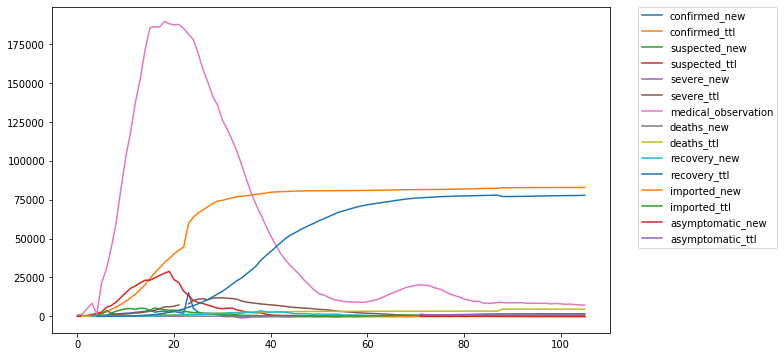

In [47]:
#Plot China raw data
china.plot(figsize=(10, 6))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [74]:
#Aggregate population info on China
ttl_pop = agegroups.groupby(['country_area','year'])['pop'].sum()
ttl_pop
China_pop_2010 = ttl_pop[3]

# Baseline: SIRD Model (Susceptible-Infected-Recovered-Dead)

Here are the differential equations used:

$$\begin{align*}
\dfrac{\delta S}{\delta t} &= - \alpha  \dfrac{I}{N} S \\
\dfrac{\delta I}{\delta t} &= \alpha  \dfrac{I}{N} S - \beta  (1 - p_{I\rightarrow D})  I - \gamma p_{I\rightarrow D}  I\\
\dfrac{\delta R}{\delta t} &= \beta  (1 - p_{I\rightarrow D})  I\\
\dfrac{\delta D}{\delta t} &= \gamma p_{I\rightarrow D}  I
\end{align*}$$

where
$$\begin{align*}
\alpha &= infection\ rate\ (1/days)\\
\beta &= recovery\ rate\\
\gamma &= death\ rate\\
\\
\frac{I}{N} &= probability\ of\ infection\\
(1 - p_{I\rightarrow D}) &= probability\ of\ recovery\\
p_{I\rightarrow D} &= probability\ of\ death
\end{align*}$$


All parameters are fixed, no time-varying rates or adjustment for different demographic groups. Just the most basic model.



In [123]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
!pip install mpld3
import mpld3
mpld3.enable_notebook()

In [184]:
N = 1439323776 #googled this estimate of total china population 2020

#Initial guesses (tweak these later/implement gridsearch)
alpha = 0.4
beta = 1/4.0
gamma = 1/9.0
p_I_to_R = 0.99
p_I_to_D = 0.01

#The original notebook fits everything based on S0, but then extracts only 
#the number of deaths. Y_data is the actual number of deaths, ret[6][x]
#is the predicted number. The two are compared.
days = 105

In [185]:
def deriv(y, t, N, alpha, beta, gamma, p_I_to_R, p_I_to_D):
    S, I, R, D = y

    dSdt = - alpha * (I / N) * S
    dIdt = alpha * (I / N) * S - beta * p_I_to_R * I - gamma * p_I_to_D * I
    dRdt = beta * p_I_to_R * I
    dDdt = gamma * p_I_to_D * I
    
    return dSdt, dIdt, dRdt, dDdt

In [186]:
def Model(days, N, alpha, beta, gamma, p_I_to_R, p_I_to_D):
    S0, I0, R0, D0 = N-1.0, 1.0, 0.0, 0.0     #initialize counts in categories
    y0 = S0, I0, R0, D0 
    
    t = np.linspace(0, 105-1, 105) # Grid of time points (in days)
    
    #fit the model
    ret = odeint(deriv, y0, t, args=(N, alpha, beta, gamma, p_I_to_R, p_I_to_D))
    S, I, R, D = ret.T
    #R_0 = alpha * (N-1.0) / beta
    return t, S, I, R, D #, R_0

In [ ]:
#def fitter(x, alpha, beta, gamma, p_I_to_R, p_I_to_D):
#    ret = Model(days, N, alpha, beta, gamma, p_I_to_R, p_I_to_D)
#    return ret

In [189]:
mod = Model(days, N, alpha, beta, gamma, p_I_to_R, p_I_to_D)
ind, S, I, R, D = mod #outputs predicted S, E, I, R based on chosen params

In [ ]:
#Plotting not working

In [136]:
def plotsir(t, S, I, R, D):
  f, ax = plt.subplots(1,1,figsize=(10,5))
  ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
  ax.plot(t, I, 'y', alpha=0.7, linewidth=2, label='Infected')
  ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
  ax.plot(t, D, 'r', alpha=0.7, linewidth=2, label='Dead')


  ax.set_xlabel('Time (days)')

  ax.yaxis.set_tick_params(length=0)
  ax.xaxis.set_tick_params(length=0)
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')
  legend = ax.legend()
  legend.get_frame().set_alpha(0.5)
  for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)
  plt.show();

ValueError: x and y must have same first dimension, but have shapes (100,) and (105,)

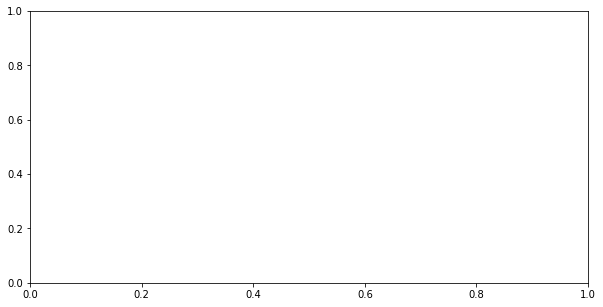

In [190]:
plotsir(t, S, I, R, D)

# SELIRCD Model

In [113]:
def Model(days, N, alpha, beta, gamma, p_I_to_R, p_I_to_D):
    # run model
    y0 = N-1.0, 1.0, 0.0, 0.0 #initialize counts in categories
    t = np.linspace(0, days, days) #listed day nums from start to end of simulation
    ret = odeint(deriv, y0, t, args=(N, alpha, beta, gamma, p_I_to_R, p_I_to_D))
    S, I, R, D = ret.T
    R_0 = alpha * (N-1.0) / beta
    return t, S, I, R, D, p_I_to_R, p_I_to_D, R_0

In [114]:
data = china["deaths_ttl"].values #cumulative number of deaths

outbreak_shift = -1
days = outbreak_shift + len(data)
if outbreak_shift >= 0:
    y_data = np.concatenate((np.zeros(outbreak_shift), data))
else:
    y_data = data[-outbreak_shift:]
    
N = 1439323776 #googled this estimate of total china population 2020
params_init_min_max = {"alpha": (0.3,0.1,1.0), 
                       "beta": (0.7,0.3,1.0), 
                       "gamma": (0.1,0.001,0.3), 
                       "p_I_to_R": (0.8,0.5,1.0),
                       "p_I_to_D": (0.02,0.001,0.5)}  # form: {parameter: (initial guess, minimum value, max value)}

x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array

In [118]:
def fitter(x, alpha, beta, gamma, p_I_to_R, p_I_to_D):
    ret = Model(days, N, alpha, beta, gamma, p_I_to_R, p_I_to_D)
    return ret

In [119]:
mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
fit_method = "leastsq"

In [120]:
result = mod.fit(y_data, params, method="least_squares", x=x_data)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''